# VSA Syntax and Control Flow

This notebook is meant as just a place to express my current thoughts on how to do large-scale VSA development.  In particular, I'm interesting in finding a programming syntax that has the right level of abstraction and flexibility, and that syntax also needs to include the ability to control the flow of a VSA system.

The vast majority of my current thoughts on this topic come from many discussions over the years at the Univesity of Waterloo Centre for Theoretical Neuroscience with many students, and especially with Jan Gosmann, who was also the primary developer for the `nengo-spa` package which instantiates many of these ideas.  https://www.nengo.ai/nengo-spa/  A lot of the ideas below are Jan's and came out of some very long discussions over the years.  

One core requirement for me is for the system to be as agnostic as possible to different VSA approaches.  Indeed, I want to be able to mix-and-match VSA approaches within the same model.  For another core requirement, I want the resulting syntax to be compatible with a Python parser (i.e. I don't want to invent a whole new language -- I'm happy doing fun things with the Python AST if necessary, but sticking with Python-compatible syntax makes things a lot simpler and accessible).

## Basic Syntax

We need to be able to refer to both variables and constants.  By convention, I'm going to use all lower-case to be a variable, and all upper-case to be a constant.  So, I might have a variable `a` that at one point in time contains the vector for `DOG` and another time contains the vector for `CAT`.

For binding, we use `*` and for bundling we use `+`.  If there is an inversion operation for the binding operator, we use `~` to indicate that.  So we could have a variable `memory` that contains `BLUE*CIRCLE+RED*SQUARE` and if we wanted to find out what color the circle is, we could compute `memory*~CIRCLE`.


## Basic Variables

When we define a variable, we tend to want to be able to configure things about it.  For example, we might want to configure what VSA is being used, and what dictionary (i.e. the mapping from symbols to vectors).  In other words, we want this to be a **strongly typed** approach.  So we'll need to be able to do something like `a = Variable(...)` and configure that variable on instantiation. 


## Basic Control Flow

We need some way to indicate that the result of some computation should be stored in a variable.  One obvious way to do that would be to say something like `memory = color*shape`, and have that mean to store the result of binding whatever is in `color` and `shape` into the variable `memory`.  However, that's not going to work in a language like Python, as that overrides whatever we'd defined `memory` to be when we instantiated it.  So instead we need something like `memory.set_to(color*shape)`, but that's rather ugly.  Another option (and what we'll use here) is to take a hint from C++ and do `color*shape >> memory`.  (We might also support `memory << color*shape`, but I like forcing it to be the other way around so as to remind myself that it's not exactly the same as an assignment statement). 



# A Simple Example

The syntax as described above is close enough to what we are using in `nengo_spa` that we can put together a simple concrete example to see how this might work.  To run this example, you will need to `pip install nengo_spa`.  We have to do a bit of configuring of `nengo` to tell it not to try to implement everything in neurons, and not to include any synapse models between components.  Also, the `nengo_spa` systems calls a variable a `State`.  

The basic model here is a simple binding and unbinding network.  We'll bind together two inputs, store that vector, and then bind the result with the inverse of a query vector to get an answer.  So if we've bound together BLUE and CIRCLE and we query it with CIRCLE, we should get BLUE out.

We also need to be able to provide inputs and outputs from our system.  In `nengo_spa`, this is a `Transcode` object, which acts like a variable but you can set its value either to be a constant or based on a function.  While these can be used for both inputs and outputs, Nengo also provides a `Probe` to record a value over time while a model is run.  We'll use that to record the answer from the network.

In [1]:
import nengo_spa as spa
import nengo

model = spa.Network()
with model:
    # configure Nengo to just directly conpute things, rather than trying to implement the
    #  network with neurons
    model.config[nengo.Ensemble].neuron_type = nengo.Direct()
    model.config[nengo.Connection].synapse = None
    
    # This defines the VSA to use, its dimensionality, and maintains the map from symbols to vectors
    #  If `strict` is True, then you have to predefine all symbols; otherwise it'll randomly generate
    #  new ones as you use them.  The default VSA to use is HRR.
    vocab = spa.Vocabulary(64, strict=False)
    
    # Define the variables, and indicate they're all using the same VSA and vocabulary
    color = spa.State(vocab)
    shape = spa.State(vocab)
    combined = spa.State(vocab)
    query = spa.State(vocab)
    answer = spa.State(vocab)
    
    # Connect it up
    color * shape >> combined
    combined * ~query >> answer
    
    # Define the inputs
    #  Note that it should be possible to infer what the vocabulary should be based on where we're
    #   connecting it to, but Nengo doesn't do that at the moment, so we have to specify that explicitly
    #  Also note that you can specify constants either as strings or via `spa.sym.X`
    spa.Transcode(spa.sym.BLUE, output_vocab=vocab) >> color
    spa.Transcode('CIRCLE', output_vocab=vocab) >> shape
    spa.Transcode(lambda t: spa.sym.CIRCLE if t<=5 else spa.sym.BLUE, output_vocab=vocab) >> query
    
    p_answer = nengo.Probe(answer.output)
    
sim = nengo.Simulator(model, dt=1, optimize=False)
sim.run(10)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Now we can plot the results.  The `Probe` records the vector coming out of the `answer` variable, so in order to interpret that we can do the dot-product of that vector with the BLUE and CIRCLE vectors in the `Vocabulary`.

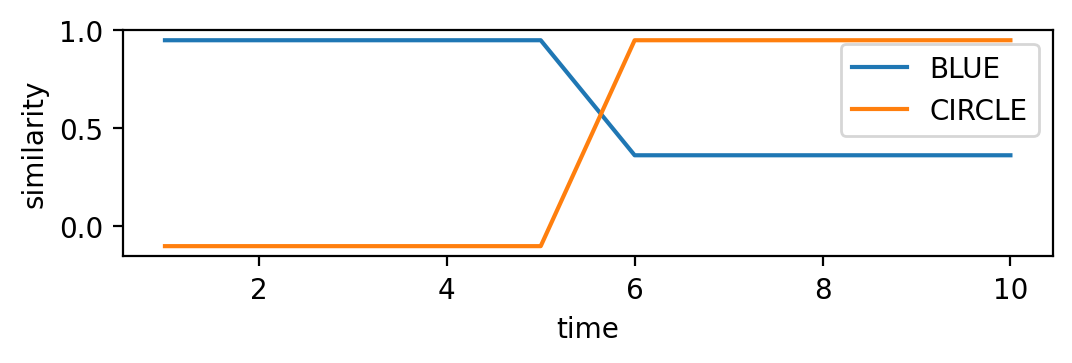

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(6,1.5), dpi=200)
plt.plot(sim.trange(), np.dot(sim.data[p_answer], vocab.vectors.T))
plt.legend(vocab.keys())
plt.xlabel('time')
plt.ylabel('similarity')
plt.show()

It works!  When the `query` changes from CIRCLE to BLUE at t=5, we get the desired change in output.

If you have `nengo_gui` installed (`pip install nengo_gui`) you can also draw the resulting network diagram.  (Note: if you try this and get an error message below, follow the instructions in the error message to configure IPython Notebook to allow the inline user interface to run.)

In [3]:
import nengo_gui.ipython
nengo_gui.ipython.InlineGUI(model)

# Timesteps

There is (at least) one surprising thing about the result above:  The network produces the correct answer *on the very first timestep!*.  How is that possible?  Given the network diagram, we have six layers in this network (The initial `Transcode` providing the input; the `shape` and `color` variables; something to do the binding of those together; the `combined` variable, the unbinding; and the `answer` variable).  

The reason this is happening is that we have specified that *no time at all* is being spent on the connections between components.  This is what setting `synapse=None` means in Nengo.  It means that when I connect two components, the input to the second component will be whatever the output was from the first component *on that same timestep*.  Exactly how this is handled when the network is run is, of course, hardware-dependent: some hardware might just not support this, or we can do fun tricks like having mulitple hardware timesteps correspond to one simulation timestep.

As for why we would want to support something like this, the main reason is that it lets me specify my expectations of the time flow of the algorithm.  In particular, I'm saying that I want the answer available on the very same timestep that the input is provided, and that's going to be important if I'm connecting this up to a larger system.  I don't want to have to count layers in order to sort out the timing.

Furthermore, having this timing expectiation be explicit in this way opens the door to a variety of optimizations available in the compilation process.  For example, because the compiler knows that the `State` variables are just variables and don't do any processing themselves, that means the compiler is free to optimize them out.  We don't actually need the `combined` variable; we can just directly do `(color*shape)*~query >> answer`.  A good compiler should be able to automatically turn that into this (further optimizations are left as an exercise to the reader).

In [4]:
import nengo_spa as spa
import nengo

model = spa.Network()
with model:
    model.config[nengo.Ensemble].neuron_type = nengo.Direct()
    model.config[nengo.Connection].synapse = None
    
    vocab = spa.Vocabulary(64, strict=False)
    
    color = spa.State(vocab)
    shape = spa.State(vocab)
    query = spa.State(vocab)
    answer = spa.State(vocab)
    
    (color*shape)*~query >> answer
    
    spa.Transcode(spa.sym.BLUE, output_vocab=vocab) >> color
    spa.Transcode('CIRCLE', output_vocab=vocab) >> shape
    spa.Transcode(lambda t: spa.sym.CIRCLE if t<=5 else spa.sym.BLUE, output_vocab=vocab) >> query
    
    p_answer = nengo.Probe(answer.output)
    
sim = nengo.Simulator(model, dt=1, optimize=False)
sim.run(10)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

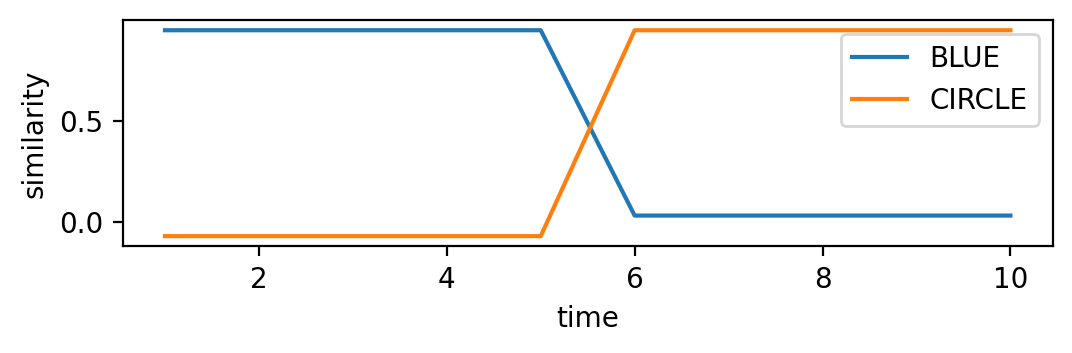

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(6,1.5), dpi=200)
plt.plot(sim.trange(), np.dot(sim.data[p_answer], vocab.vectors.T))
plt.legend(vocab.keys())
plt.xlabel('time')
plt.ylabel('similarity')
plt.show()

Of course, even if we do specify that we want a one-time-step delay on each connection, then the compiler would still be free to do this sort of optimization; it would just have to also add in some delays to make sure everything works out how the user expects.

In Nengo, for historical reasons the way of specifying a one-time-step delay is the unintuitive process of setting `synapse=0`.  Since that is a bit weird, there's also the alternative provided by `nengolib` (`pip install nengolib`) of explicitly using the discrete-time operator `z` and specifying `synapse=z**(-1)` (or whatever other delay you want).  (Note: in general, Nengo allows for arbitrary continuous and discrete linear filters to be applied at any connection between components, so this is just a special case of that overall system).

In [6]:
import nengo_spa as spa
import nengo

model = spa.Network()
with model:
    model.config[nengo.Ensemble].neuron_type = nengo.Direct()
    model.config[nengo.Connection].synapse = 0       # this actually means one timestep!
    
    vocab = spa.Vocabulary(64, strict=False)
    
    color = spa.State(vocab)
    shape = spa.State(vocab)
    query = spa.State(vocab)
    answer = spa.State(vocab)
    
    (color*shape)*~query >> answer
    
    spa.Transcode(spa.sym.BLUE, output_vocab=vocab) >> color
    spa.Transcode('CIRCLE', output_vocab=vocab) >> shape
    spa.Transcode(lambda t: spa.sym.CIRCLE if t<=5 else spa.sym.BLUE, output_vocab=vocab) >> query
    
    p_answer = nengo.Probe(answer.output)
    
sim = nengo.Simulator(model, dt=1, optimize=False)
sim.run(10)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

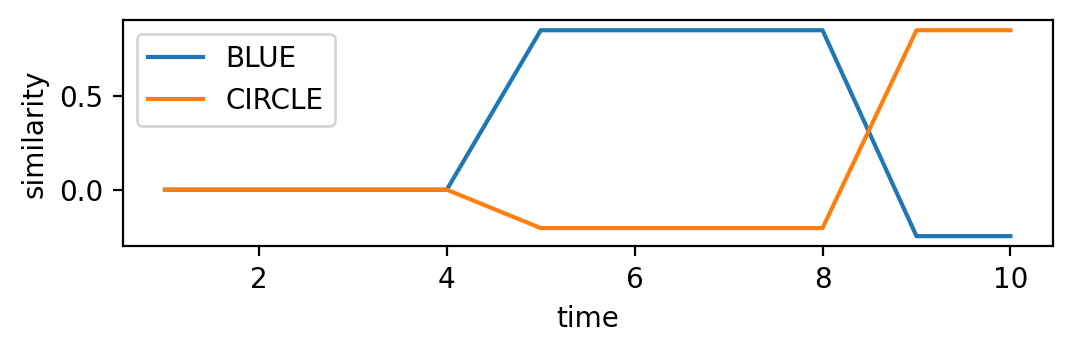

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(6,1.5), dpi=200)
plt.plot(sim.trange(), np.dot(sim.data[p_answer], vocab.vectors.T))
plt.legend(vocab.keys())
plt.xlabel('time')
plt.ylabel('similarity')
plt.show()

Now that we have one way of controlling the flow of time in our network, we can use this to start implementing algorithms.  For example, let's turn our `combined` variable into a memory.  That is, rather than having the variable go back to zero if the input is removed, let's have it remember its value.  An easy way to do this is just to connect it back to itself.  But, of course, when we do this we need to specify that there should be a one-time-step delay here (i.e. the input should be the output on the previous time-step). (If you try to make a recurrent loop like this all with `synapse=None`, the compiler will give you an error since that's impossible).

If we get multiple inputs at the same time, I think the default thing that should happen would be to take the sum of the inputs (or, more generally, use whatever bundling operator is defined on your VSA).  In this case, this means we can build up a memory by inputing multiple pairs of vectors over time, and then later query any of them.  In the following case, we will input a BLUE CIRCLE and then a RED SQUARE, and the `memory` vector should end up at `BLUE*CIRCLE+RED*SQUARE`.

In [8]:
import nengo_spa as spa
import nengo

model = spa.Network()
with model:
    model.config[nengo.Ensemble].neuron_type = nengo.Direct()
    model.config[nengo.Connection].synapse = None
    
    vocab = spa.Vocabulary(64, strict=False)
    
    color = spa.State(vocab)
    shape = spa.State(vocab)
    memory = spa.State(vocab) 
    query = spa.State(vocab)
    answer = spa.State(vocab)
    
    color * shape >> memory
    memory * ~query >> answer
    
    # make sure the connection from memory back to itself has a one-time-step delay
    model.config[nengo.Connection].synapse = 0
    memory >> memory
    model.config[nengo.Connection].synapse = None
    
    # present two different inputs on the first two timesteps
    spa.Transcode(lambda t: 'BLUE' if t<=1 else ('RED' if t<=2 else '0'), output_vocab=vocab) >> color
    spa.Transcode(lambda t: 'CIRCLE' if t<=1 else ('SQUARE' if t<=2 else '0'), output_vocab=vocab) >> shape
    
    # present 4 queries, starting at t=5
    def query_func(t):
        if 5<t<=6: return 'BLUE'
        if 6<t<=7: return 'CIRCLE'
        if 7<t<=8: return 'RED'
        if 8<t<=9: return 'SQUARE'
        return '0'
    spa.Transcode(query_func, output_vocab=vocab) >> query
    
    p_answer = nengo.Probe(answer.output)
    p_query = nengo.Probe(query.output)
    
sim = nengo.Simulator(model, dt=1, optimize=False)
sim.run(10)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

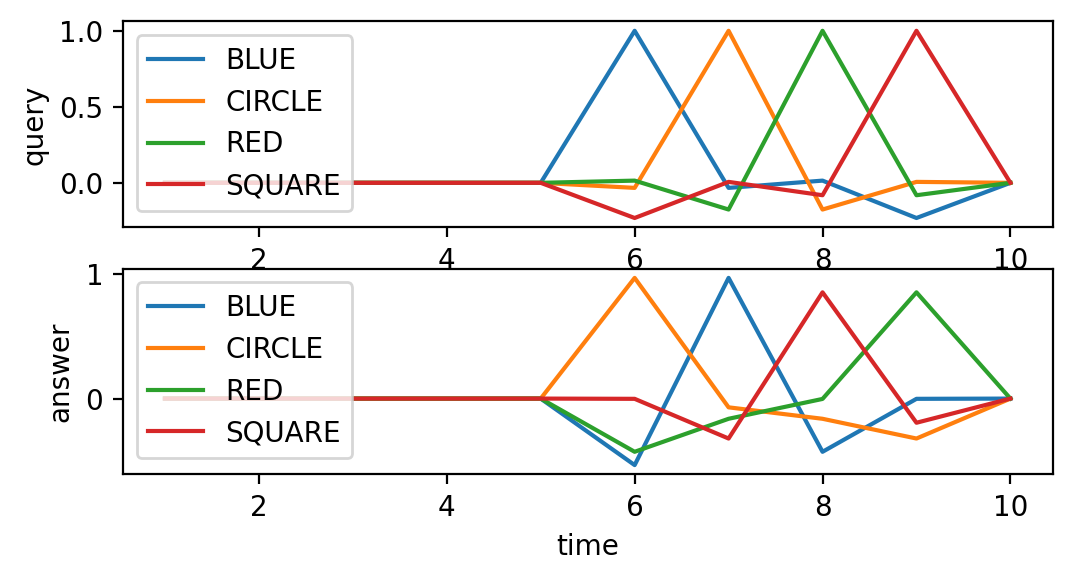

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(6,3), dpi=200)
plt.subplot(2, 1, 1)
plt.plot(sim.trange(), np.dot(sim.data[p_query], vocab.vectors.T))
plt.legend(vocab.keys(), loc='upper left')
plt.ylabel('query')
plt.subplot(2, 1, 2)
plt.plot(sim.trange(), np.dot(sim.data[p_answer], vocab.vectors.T))
plt.legend(vocab.keys(), loc='upper left')
plt.xlabel('time')
plt.ylabel('answer')
plt.show()

Overall, I find this ability to control the flow of time to be extremely important when building up VSA-style algorithms.  However, it is unclear to me what the best syntax for this sort of thing might be.  The syntax shown above (i.e. setting the `synapse` parameter) is rather opaque and confusing to new readers.  However, one other option that makes things a bit more clear would be to use a context manager, so you could do something like this:

```python
    with no_delay:
        color * shape >> memory
        memory * ~query >> answer
    with single_step_delay:
        memory >> memory
```

Nengo also has support for this approach, although it doesn't quite have the semantics I think I'd want.  In particular, it interprets the `single_step_delay` as being defined at the level of connections between components, rather than at the level of the overall statement.  This means that if I did this:

```python
    with single_step_delay:
        color * shape >> memory
```

I'd actually get a two-time-step delay -- one for taking `color` and `shape` and feeding them into the binding operation, and one for taking the output of the binding and feeding it to `memory`.  I can get around this by doing the following:

```python
    with no_delay:
        temp = color * shape    # note the assignment statement here!
    with single_step_delay:
        temp >> memory
```

In any case, for the particular case we have for the `memory` system, this isn't a problem as the semantics fit with what we want:

In [10]:
import nengo_spa as spa
import nengo

# define the parameters to use in different contexts
no_delay = nengo.Config(nengo.Connection)
no_delay[nengo.Connection].synapse = None

single_step_delay = nengo.Config(nengo.Connection)
single_step_delay[nengo.Connection].synapse = 0


model = spa.Network()
with model:
    model.config[nengo.Ensemble].neuron_type = nengo.Direct()
    
    vocab = spa.Vocabulary(64, strict=False)
    
    color = spa.State(vocab)
    shape = spa.State(vocab)
    memory = spa.State(vocab) 
    query = spa.State(vocab)
    answer = spa.State(vocab)
    
    with no_delay:
        color * shape >> memory
        memory * ~query >> answer
    
    with single_step_delay:
        memory >> memory
    
    with no_delay:
        spa.Transcode(lambda t: 'BLUE' if t<=1 else ('RED' if t<=2 else '0'), output_vocab=vocab) >> color
        spa.Transcode(lambda t: 'CIRCLE' if t<=1 else ('SQUARE' if t<=2 else '0'), output_vocab=vocab) >> shape
    
    def query_func(t):
        if 5<t<=6: return 'BLUE'
        if 6<t<=7: return 'CIRCLE'
        if 7<t<=8: return 'RED'
        if 8<t<=9: return 'SQUARE'
        return '0'
    with no_delay:
        spa.Transcode(query_func, output_vocab=vocab) >> query
    
    p_answer = nengo.Probe(answer.output)
    p_query = nengo.Probe(query.output)
    
sim = nengo.Simulator(model, dt=1, optimize=False)
sim.run(10)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

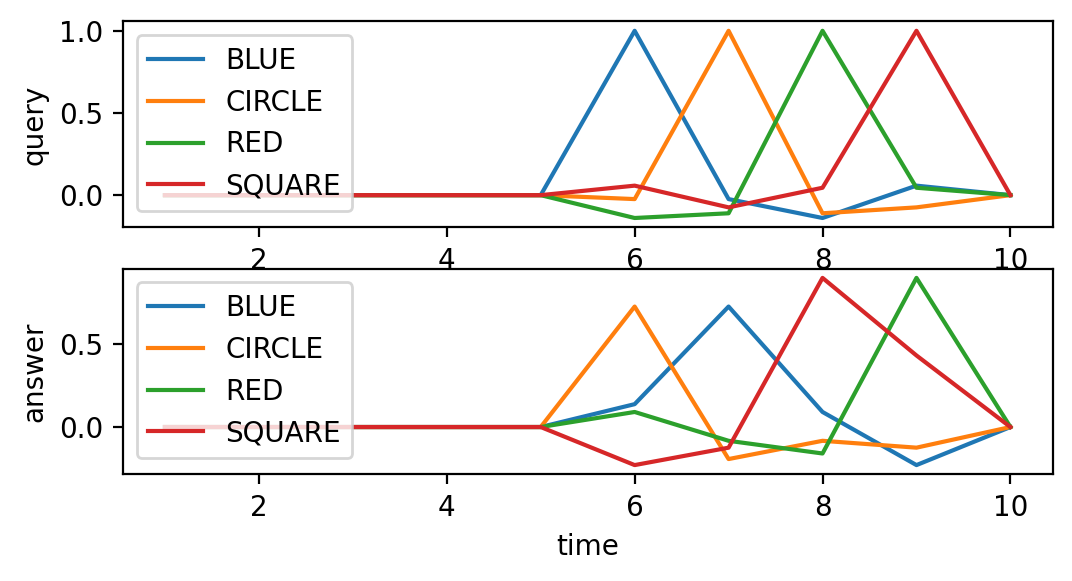

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(6,3), dpi=200)
plt.subplot(2, 1, 1)
plt.plot(sim.trange(), np.dot(sim.data[p_query], vocab.vectors.T))
plt.legend(vocab.keys(), loc='upper left')
plt.ylabel('query')
plt.subplot(2, 1, 2)
plt.plot(sim.trange(), np.dot(sim.data[p_answer], vocab.vectors.T))
plt.legend(vocab.keys(), loc='upper left')
plt.xlabel('time')
plt.ylabel('answer')
plt.show()

Another possibility that has been talked about, but not implemented yet, is to try something like this:

```python
    memory.delay(1) >> memory
```

Or perhaps this, if people like discrete-time operators:

```python
    memory.z**(-1) >> memory
```

Or perhaps this, in reference to timesteps:

```python
    memory.t[-1] >> memory
```


Or maybe even this, although it might be easily confused with referring to the last value in the VSA vector:

```python
    memory[-1] >> memory
```


# Combining Vocabularies and VSAs

When building up a large system, we generally don't want to use the same VSA everywhere.  This might involve just changing dimensionality (maybe my vision system uses 1000-dimensional vectors while my planning and reasoning system uses 500-dimensional, for example).  Or maybe I want entirely different VSA approaches in different parts of the model, such as using HRRs in one part and MAP in another and FHRRs elsewhere.  This means we're going to need some way of translating between them.

I think there's three different classes of processing that I might want to do here.  

First, I might want to do nothing at all.  If the vectors are the same dimensionality, I can imagine there are situations where I just want to keep the vector the same and just interpret it differently in different parts of the system.  However, this is probably a pretty rare thing to want to do, but I think it should be supported.

Second, I might want to do a *linear* transform between the two VSAs.  There are lots of different possible ways of converting, but a linear transformation is a pretty simple one.  In particular, I tend to use a matrix built from the outer product of the vector representation of items in the two different VSAs (see below for an example).

Third, I might want any one of a large number of *non-linear* operations to convert between Vocabularies.  This could involve winner-take-all type circuits or any number of a variety of options.  One example would be an Associative Memory -- i.e. a system that is just a Cleanup Memory but where the output is in some different space as the input.  (Indeed, I often think of Cleanup Memories as a special case of an Associative Memory where the input and output vocabularies are the same).  

Since there are a large number of configuration options for the third option (there are many different types of non-linearities I might want there), as far as programming syntax goes I tend to think of the third option as introducing a new component to my system (kind of like a `Variable`, but one where I feed in input in one VSA and it comes out in a different VSA).  For the first and second option, however, since they are simpler (nothing at all or a linear transform, respectively), I instead think it's clearer to handle that while passing data from one place to the next.  For example, given the syntax above, if I wrote `a >> b` and both `a` and `b` used different `Vocabularies`, then I might want to automatically do this conversion without any syntax at all.  This would be sort of like not requiring an explicit cast when converting a variable from one type to another (e.g. `int d = (int)(a+b/c)`).   However, in practice I found that having this happen automatically just led to more problems as I'd often forget that different parts of my system were using different VSAs.  Having some explicit notation at least indicates that some conversion is happening.  For `nengo_spa` we went with `a.translate(vocab) >> b`, where the `vocab` argument tells you what VSA to translate to.  The system then inspects whatever symbols are in `vocab` and in the Vocabulary used by `a` (specified when it was initialized) and build up the sum of the outer products of any symbols that are defined in both Vocabularies.  If you want to do nothing at all, then the syntax is `a.reinterpret(vocab) >> b`

Below are two examples of using this approach, one using the linear map and one using the associative memory.

### Linear Mapping Between VSAs

In the following model we have two vocabularies, one containing three-letter words (CAT, DOG, HAT, CAR) and one containing animals (DOG, CAT, MOUSE, ELEPHANT).  The first is 64-dimensional and the second is 512-dimensional, but they could also be the same dimensionality.

If I try to directly connect a variable using the first vocabulary to one using the second vocabulary, one thing I might want is that if the first variable contains DOG, then that should drive the second variable to its representation of DOG.  And, indeed, if the first contained DOG+CAT, then we would also get out DOG+CAT.

One simple way to do this for many VSAs is to generate a matrix formed by summing together the outer products of the two different representations for each term.  That is, we compute $CAT_1 \times CAT_2 + DOG_1 \times DOG_2$ and then use the resulting matrix as a linear transform that maps from one vocabulary to the next.  

It should be noted that, while this method is pretty simple, it does rely on the vectors being known at the time of construction of the model.  That's why we do the `vocab.populate` command to make sure those are generated.

c:\users\terry\git\nengo-spa\nengo_spa\vocabulary.py:372: NengoWarning: The transform_to source vocabulary has keys not existent in the target vocabulary. These will be ignored. Use the `populate=False` keyword argument to silence this warning or `populate=True` to automatically add missing keys to the target vocabulary.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

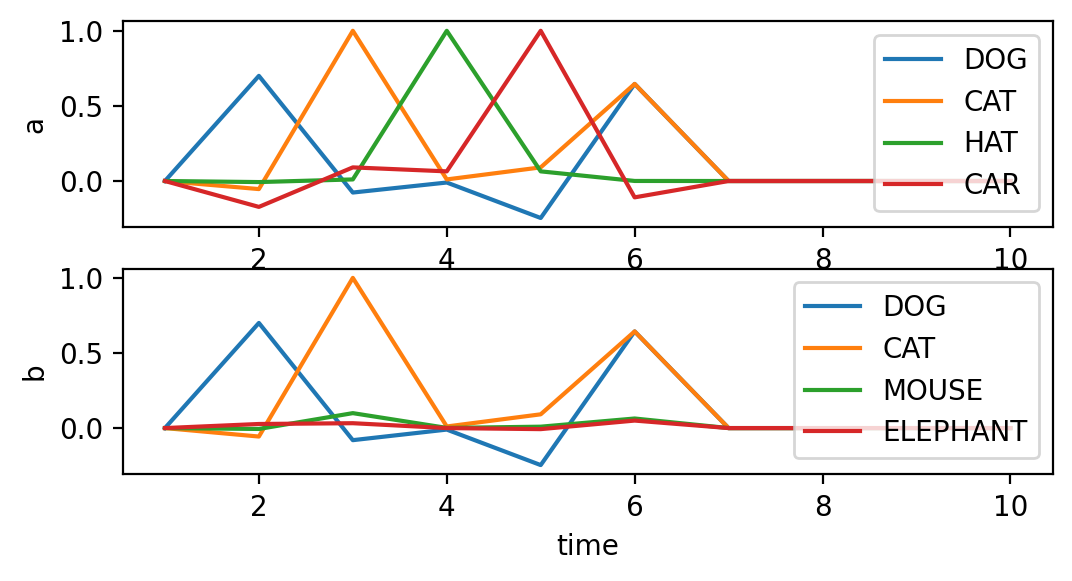

In [12]:
import nengo_spa as spa
import nengo

model = spa.Network()
with model:
    model.config[nengo.Ensemble].neuron_type = nengo.Direct()
    model.config[nengo.Connection].synapse = None
    
    vocab1 = spa.Vocabulary(64)
    vocab1.populate('DOG;CAT;HAT;CAR')    # pre-populate the vocabulary so that we have generated vectors
    vocab2 = spa.Vocabulary(512)
    vocab2.populate('DOG;CAT;MOUSE;ELEPHANT') # pre-populate the vocabulary so that we have generated vectors
    
    a = spa.State(vocab1)  # use different vocabularies for the two components
    b = spa.State(vocab2)
    
    def input_func(t):
        if 1<t<=2: return '0.7*DOG'
        if 2<t<=3: return 'CAT'
        if 3<t<=4: return 'HAT'
        if 4<t<=5: return 'CAR'
        if 5<t<=6: return '0.7*DOG+0.7*CAT'        
        return '0'
    spa.Transcode(input_func, output_vocab=vocab1) >> a
    
    # translate from one to the other
    a.translate(vocab2) >> b
    
    p_in = nengo.Probe(a.output)
    p_out = nengo.Probe(b.output)
    
sim = nengo.Simulator(model, dt=1, optimize=False)
sim.run(10)

plt.figure(figsize=(6,3), dpi=200)
plt.subplot(2, 1, 1)
plt.plot(sim.trange(), np.dot(sim.data[p_in], vocab1.vectors.T))
plt.legend(vocab1.keys(), loc='upper right')
plt.ylabel('a')
plt.subplot(2, 1, 2)
plt.plot(sim.trange(), np.dot(sim.data[p_out], vocab2.vectors.T))
plt.legend(vocab2.keys(), loc='upper right')
plt.xlabel('time')
plt.ylabel('b')
plt.show()

### Non-Linear Mapping Between VSAs

(sort of like a cleanup memory but using two different Vocabularies)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

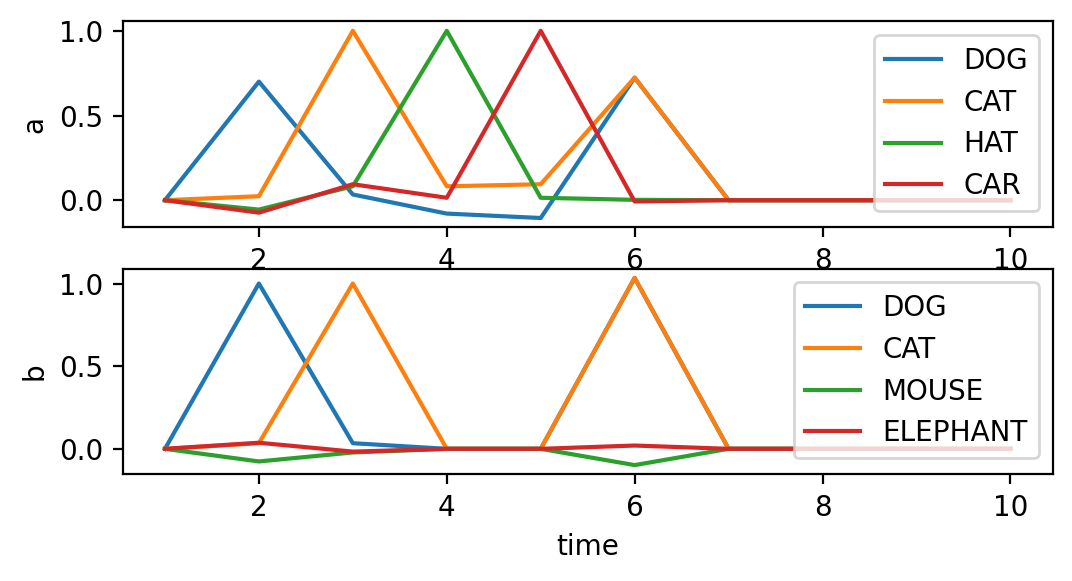

In [13]:
import nengo_spa as spa
import nengo

model = spa.Network()
with model:
    model.config[nengo.Ensemble].neuron_type = nengo.Direct()
    model.config[nengo.Connection].synapse = None
    
    vocab1 = spa.Vocabulary(64)
    vocab1.populate('DOG;CAT;HAT;CAR')    # pre-populate the vocabulary so that we have generated vectors
    vocab2 = spa.Vocabulary(512)
    vocab2.populate('DOG;CAT;MOUSE;ELEPHANT') # pre-populate the vocabulary so that we have generated vectors
    
    a = spa.State(vocab1)  # use different vocabularies for the two components
    b = spa.State(vocab2)
    
    # 
    am = spa.ThresholdingAssocMem(input_vocab=vocab1, output_vocab=vocab2, threshold=0.3, mapping=['DOG','CAT'], function=lambda x: x > 0.3)
    
    def input_func(t):
        if 1<t<=2: return '0.7*DOG'
        if 2<t<=3: return 'CAT'
        if 3<t<=4: return 'HAT'
        if 4<t<=5: return 'CAR'
        if 5<t<=6: return '0.7*DOG+0.7*CAT'        
        return '0'
    spa.Transcode(input_func, output_vocab=vocab1) >> a
    
    # translate from one to the other
    a >> am
    am >> b
    
    p_in = nengo.Probe(a.output)
    p_out = nengo.Probe(b.output)
    
sim = nengo.Simulator(model, dt=1, optimize=False)
sim.run(10)

plt.figure(figsize=(6,3), dpi=200)
plt.subplot(2, 1, 1)
plt.plot(sim.trange(), np.dot(sim.data[p_in], vocab1.vectors.T))
plt.legend(vocab1.keys(), loc='upper right')
plt.ylabel('a')
plt.subplot(2, 1, 2)
plt.plot(sim.trange(), np.dot(sim.data[p_out], vocab2.vectors.T))
plt.legend(vocab2.keys(), loc='upper right')
plt.xlabel('time')
plt.ylabel('b')
plt.show()

# More advanced control flow

Have a bunch of different actions and choose 1 based on some state similarity measure (i.e. do the action that is the closest match)

(or maybe do weighted versions of each action based on the similarity?  Many options)

In [ ]:
# Switch statements and/or ifmax


match state:
    case 'DOG':
        'PET' >> action
    case 'CAT':
        'FEED' >> action

            
        
